# ¿Quiénes se benefician más de formalizar su trabajo?

> El beneficio de trabajar para una empresa formal crece con la edad y educación. Es mayor en el área rural y entre hombres. Para personas menores a 35 años, el trabajo informal suele ser más rentable.

*¿Cuál es el premium de trabajar para una empresa formal y quiénes se benefician más de formalizar su trabajo?*

Comparo el ingreso medio de trabajadores formales como el porcentaje del ingreso de informales para distintos cohortes demográficos. Encuentro que el premium de trabajar en una empresa formal crece con la edad y el nivel de educación, que es mayor en el área rural y entre hombres que trabajan en empresas en el Régimen General, en comparación al simplificado, y particularmente alto en el área rural de Potosí. Además encuentro que entre personas menores a 35 años, trabajar en una actividad informal suele ser más rentable. 

Las siguientes gráficas ilustran estas comparaciones a través de departamentos, áreas, género, rango de edad y nivel educativo para individuos que trabajan en empresas inscritas al Régimen Simplificado y al Régimen General. El color de cada cuadro corresponde al ingreso medio en una actividad formal como porcentaje del ingreso en una actividad informal. Considero *ingreso* como el ingreso neto o salario líquido, según su disponibilidad en la base de datos. Finalmente, sólo tomo en cuenta comparaciones en grupos con al menos 10 individuos.

In [736]:
import pandas as pd
import pdfplumber
import json
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
import numpy as np
import re
from collections import ChainMap
from textwrap import wrap
import unicodedata
from IPython.display import display, Markdown
import math

pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=100
plt.style.use('publish/estilo.mplstyle')

In [2]:
def get_caeb(pdf_filename):
    """
    Construye un diccionario de los códigos y nombres en 
    la Clasificación de Actividades Económicas de Bolivia.
    """
    
    pdf = pdfplumber.open(pdf_filename)
    caeb = {}
    for i, page in enumerate(pdf.pages[28:62]):
        rows = page.extract_text().split('\n')
        rows = rows[[i + 1 for i, row in enumerate(rows) if 'DESCRIPCIÓN' in row][0]:-1]
        for row in rows:
            categoria = re.findall('^[A-Z]\s\s\s\s+', row)
            if len(categoria) > 0:
                cat = categoria[0].strip()
                caeb[cat] = []
            actividad = re.findall('[0-9]+', row)
            if len(actividad) > 0:
                caeb[cat].append(actividad[0])

    actividades = [{actividad:key for actividad in caeb[key]} for key in caeb.keys()]
    actividades = dict(ChainMap(*actividades))
    caeb = {**actividades, **{key:key for key in caeb.keys()}}

    return caeb

def get_cob(pdf_filename):
    """
    Construye un diccionario de los códigos y nombres en 
    la Clasificación de Ocupaciones de Bolivia 2009.
    """
    
    pdf = pdfplumber.open(pdf_filename)
    cob = {}
    before_nombre = ''
    
    for i, page in enumerate(pdf.pages[29:43]):

        p = unicodedata.normalize(u'NFKD', page.extract_text()).encode('ascii', 'ignore').decode('utf8')
        rows = re.split('\n(?=[\s0-9])', p)
        rows = rows[[i + 1 for i, row in enumerate(rows) if 'DESCRIPCION' in row][0]:-1]

        for row in rows:
            
            codigo = re.findall('[0-9]+', row)[0]
            nombre = re.findall('[A-Za-z][A-Za-z\s\/\;\,\.\:\(\)\[\]\{\}\-\_]+', row)[0].lower()
            
            if '\n' in nombre:
                
                nombre_split = nombre.split('\n')
                nombre = ' '.join([before_nombre, nombre_split[0]])
                before_nombre = ' '.join(nombre_split[1:])
            
            else:
                
                nombre = ' '.join([before_nombre, nombre])
                before_nombre = ''
                
            cob[codigo] = nombre.strip()

    return cob

def flatten_cob(cob, level=2):
    """
    Aplana entradas en el diccionario de ocupaciones a
    un nivel específico para facilitar operaciones agregadas
    """
    
    cob2 = {}
    categories = [c for c in cob.keys() if len(c) == level]
    i = -1
    
    for c in cob.keys():
        
        nivel = len(c)
        
        if nivel == level:
            i += 1
            cob2[c] = cob[categories[i]]
        elif nivel > level and c[:level] == categories[i]:
            cob2[c] = cob[categories[i]]
        elif nivel < level:
            cob2[c] = cob[categories[i + 1]]
            
    return cob2

def diccionarios(ocupaciones_nivel):
    """
    Retorna los diccionarios necesarios para intepretar
    valores en la encuesta.
    """
    
    actividades = {
        'A': 'agricultura, ganadería, caza , pesca y silvicultura',
        'B': 'explotación de minas y canteras',
        'C': 'industria manufacturera',
        'D': 'suministro de electricidad, gas, vapor y aire acondicionado',
        'E': 'suministro de agua; evacuación de aguas residuales, gestión de desechos y descontaminación',
        'F': 'construcción',
        'G': 'venta por mayor y por menor; reparación de vehículos automotores y motocicletas',
        'H': 'transporte y almacenamiento',
        'I': 'actividades de alojamiento y servicio de comidas',
        'J': 'información y comunicaciones',
        'K': 'intermediación financiera y seguros',
        'L': 'actividades inmobiliarias',
        'M': 'servicios profesionales y técnicos',
        'N': 'actividades de servicios administrativos y de apoyo',
        'O': 'administración pública, defensa y planes de seguridad social de afiliación obligatoria',
        'P': 'servicios de educación',
        'Q': 'servicios de salud y de asistencia social',
        'R': 'actividades artísticas, de entretenimiento y recreativas',
        'S': 'otras actividades de servicios',
        'T': 'actividades de hogares privados como empleadores',
        'U': 'servicios de organizaciones y órganos extraterritoriales'
    }

    niveles_educativos = {
        10: 'ninguno y no sabe leer y escribir',
        11: 'ninguno pero sabe leer y escribir',
        12: 'programa de alfabetización',
        13: 'educación inicial o pre-escolar (pre kinder/kinder)',
        21: 'sistema escolar antiguo - básico (1 a 5 años)',
        22: 'sistema escolar antiguo - intermedio (1 a 3 años)',
        23: 'sistema escolar antiguo - medio (1 a 4 años)',
        31: 'sistema escolar anterior - primaria (1 a 8 años)',
        32: 'sistema escolar anterior - secundaria (1 a 4 años)',
        41: 'sistema escolar actual - primaria (1 a 6 años)',
        42: 'sistema escolar actual - secundaria (1 a 6 años)',
        51: 'educación de adultos (sistema antiguo) - educación básica de adultos (eba)',
        52: 'educación de adultos (sistema antiguo) - centro de educación media de adultos (cema)',
        61: 'educación alternativa y especial - educación juvenil alternativa (eja)',
        62: 'educación alternativa y especial - educación primaria para adultos (epa)',
        63: 'educación alternativa y especial - educación secundaria para adultos (esa)',
        64: 'educación alternativa y especial - programa nacional de post alfabetización',
        65: 'educación alternativa y especial - educación especial',
        71: 'educación superior - normal (escuela sup. de formación de maestros)',
        72: 'educación superior - universidad pública (licenciatura)',
        73: 'educación superior - universidad privada (licenciatura)',
        74: 'educación superior - postgrado diplomado',
        75: 'educación superior - postgrado maestría',
        76: 'educación superior - postgrado doctorado',
        77: 'educación superior - técnico de universidad',
        78: 'técnico de instituto (duración mayor o igual a 1 año)',
        79: 'institutos de formación militar y policial',
        80: 'educación técnica de adultos (eta)',
        81: 'otros cursos (duración menor a 1 año)'
    }

    deptos = {
        1: 'Chuquisaca',
        2: 'La Paz',
        3: 'Cochabamba',
        4: 'Oruro',
        5: 'Potosí',
        6: 'Tarija',
        7: 'Santa Cruz',
        8: 'Beni',
        9: 'Pando'
    }
    
    caeb = get_caeb('data/CAEB_2011.pdf')
    municipios = pd.read_csv('data/municipios.csv', index_col='cod_ine').municipio
    cob = get_cob('data/COB_2009.pdf')
    ocupaciones = flatten_cob(cob, ocupaciones_nivel)
    
    return caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones, cob

def format_data(dfi, caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones):
    """
    Formatea datos de la encuesta con los diccionarios y 
    las funciones disponibles.
    """
    
    def dateformat_nacimiento(x):
        if x[0] != ' ':
            try:
                return dt.datetime.strptime('{}-{}-{}'.format(x[0], x[1], x[2]), '%Y-%m-%d')
            except Exception as e:
                return None
        else:
            return None
    
    def parse_año(dfi):
        dfi['año'] = dfi['año'].astype(int)
        return dfi
    
    def parse_trimestre(dfi):
        dfi['trimestre'] = dfi['trimestre'].astype(int)
        return dfi
    
    def parse_dep(dfi):
        dfi['dep'] = dfi.dep.map(deptos)
        return dfi
    
    def parse_area(dfi):
        dfi['area'] = dfi['area'].map({1: 'urbana', 2: 'rural'})
        return dfi
    
    def parse_sexo(dfi):
        dfi['sexo'] = dfi['sexo'].map({1: 'hombre', 2: 'mujer'})
        return dfi
    
    def parse_nacimiento(dfi):
        i = dfi.columns.tolist().index('nacimiento_año')
        dfi.insert(i, 'nacimiento', dfi[['nacimiento_año', 'nacimiento_mes', 'nacimiento_dia']].apply(lambda x: dateformat_nacimiento(x), axis=1))
        dfi.drop(columns=['nacimiento_año', 'nacimiento_mes', 'nacimiento_dia'], inplace=True)
        return dfi
    
    def parse_educacion(dfi):
        dfi['educacion'] = dfi.educacion.apply(lambda x: int(x) if x != ' ' else None).map(niveles_educativos)
        return dfi
    
    def parse_años_estudio(dfi):
        dfi['años_estudio'] = pd.to_numeric(dfi.años_estudio, errors='coerce')
        return dfi
    
    def parse_nivel_educativo(dfi):
        dfi['nivel_educativo'] = pd.to_numeric(dfi.nivel_educativo, errors='coerce').map({0: 'ninguno', 1.0: 'primaria incompleta', 2.0: 'primaria completa', 3.0:'secundaria incompleta', 4.0:'secundaria completa', 5.0:'superior', 7.0:'otro'})
        return dfi
    
    def parse_trabaja_semana(dfi):
        dfi['trabaja_semana'] = dfi.trabaja_semana.map({'1': 'si', '2': 'no'})
        return dfi
    
    def parse_trabaja(dfi):
        dfi['trabaja'] = dfi.trabaja.map({'1': 'si', '2': 'no'})
        return dfi
    
    def parse_municipio(dfi):
        dfi['municipio'] = pd.to_numeric(dfi.municipio, errors='coerce')
        return dfi
    
    def parse_actividad(dfi):
        dfi['actividad'] = dfi['actividad'].map(caeb).map(actividades)
        return dfi
    
    def parse_ocupacion(dfi):
        dfi['ocupacion'] = dfi['ocupacion'].map(ocupaciones)
        return dfi
    
    def parse_horas_semana(dfi):
        dfi['horas_semana'] = pd.to_numeric(dfi.horas_semana, errors='coerce')
        return dfi
    
    def parse_tiempo(dfi):
        dfi['tiempo_unidad'] = pd.to_numeric(dfi.tiempo_unidad, errors='coerce').map({2: 1/53, 4: 1/12, 8: 1})
        dfi['tiempo'] = pd.to_numeric(dfi.tiempo, errors='coerce') * dfi.tiempo_unidad
        dfi.drop(columns=['tiempo_unidad'], inplace=True)
        return dfi
    
    def parse_nit(dfi):
        dfi['nit'] = dfi.nit.map({'1': 'regimen general', '2': 'regimen simplificado', '3': 'no tiene'})
        return dfi
    
    def parse_tamaño_empresa(dfi):
        dfi['tamaño_empresa'] = pd.to_numeric(dfi.tamaño_empresa, errors='coerce')
        return dfi
    
    def parse_salario(dfi):
        dfi['salario'] = pd.to_numeric(dfi.salario, errors='coerce')
        dfi['salario_frecuencia'] = pd.to_numeric(dfi.salario_frecuencia, errors='coerce').map({1.0: 1.0, 2.0: 1/7, 3.0: 1/15, 4.0: 1/30, 5.0: 1/60, 6.0:1/90, 7.0:1/180, 8.0:1/365})
        dfi['salario'] = dfi.salario * dfi.salario_frecuencia
        dfi.drop(columns=['salario_frecuencia'], inplace=True)
        return dfi
    
    def parse_ingreso(dfi):
        dfi['ingreso'] = pd.to_numeric(dfi.ingreso, errors='coerce')
        dfi['ingreso_frecuencia'] = pd.to_numeric(dfi.ingreso_frecuencia, errors='coerce').map({1.0: 1.0, 2.0: 1/7, 3.0: 1/15, 4.0: 1/30, 5.0: 1/60, 6.0:1/90, 7.0:1/180, 8.0:1/365})
        dfi['ingreso'] = dfi.ingreso * dfi.ingreso_frecuencia
        dfi.drop(columns=['ingreso_frecuencia'], inplace=True)
        return dfi
    
    def parse_trabaja_semana_2(dfi):
        dfi['trabaja_semana_2'] = dfi['trabaja_semana_2'].map({'1': 'si', '2': 'no'})
        return dfi
    
    def parse_trabaja_2(dfi):
        dfi['trabaja_2'] = dfi['trabaja_2'].map({'1': 'si', '2': 'no'})
        return dfi
    
    def parse_ocupacion_2(dfi):
        dfi['ocupacion_2'] = dfi['ocupacion_2'].map(ocupaciones)
        return dfi
    
    def parse_actividad_2(dfi):
        dfi['actividad_2'] = dfi['actividad_2'].map(caeb).map(actividades)
        return dfi
    
    parsers = {
        'año': parse_año,
        'trimestre': parse_trimestre,
        'dep': parse_dep,
        'area': parse_area,
        'sexo': parse_sexo,
        'nacimiento_año': parse_nacimiento,
        'educacion': parse_educacion,
        'años_estudio': parse_años_estudio,
        'nivel_educativo': parse_nivel_educativo,
        'trabaja_semana': parse_trabaja_semana,
        'trabaja': parse_trabaja,
        'municipio': parse_municipio,
        'actividad': parse_actividad,
        'ocupacion': parse_ocupacion,
        'horas_semana': parse_horas_semana,
        'tiempo': parse_tiempo,
        'nit': parse_nit,
        'tamaño_empresa': parse_tamaño_empresa,
        'salario': parse_salario,
        'ingreso': parse_ingreso,
        'trabaja_semana_2': parse_trabaja_semana_2,
        'trabaja_2': parse_trabaja_2,
        'ocupacion_2': parse_ocupacion_2,
        'actividad_2': parse_actividad_2
    }
   
    for col in parsers.keys():
        if col in dfi.columns:
            dfi = parsers[col](dfi)    
    
    return dfi
    
def load_data(column_filter):
    """
    Carga una serie de columnas de la encuesta, cambia sus nombres
    a nombres más fáciles de interpretar y devuelve una tabla
    con el orden de columnas provisto.
    """
    
    column_names = {
        'id_per_panel': 'id_panel',
        'panel': 'panel',
        'gestion': 'año',
        'trimestre': 'trimestre',
        'depto': 'dep',
        'area': 'area',
        's1_02': 'sexo',
        's1_03ba': 'nacimiento_dia',
        's1_03bb': 'nacimiento_mes',
        's1_03bc': 'nacimiento_año',
        's1_07a': 'educacion',
        'aestudio': 'años_estudio',
        'niv_ed': 'nivel_educativo',
        's2_01': 'trabaja_semana',
        's2_14': 'trabaja',
        's2_39deptocod': 'municipio',
        's2_16acod': 'actividad',
        's2_15acod': 'ocupacion',
        'phrs': 'horas_semana',
        's2_19a_t': 'tiempo',
        's2_19a_p': 'tiempo_unidad',
        's2_23': 'nit',
        's2_26': 'tamaño_empresa',
        's2_33_v': 'salario',
        's2_33_f': 'salario_frecuencia',
        's2_38_v': 'ingreso',
        's2_38_f': 'ingreso_frecuencia',
        's2_42': 'trabaja_semana_2',
        's2_43': 'trabaja_2',
        's2_44acod': 'ocupacion_2',
        's2_45acod': 'actividad_2'
    }
    
    dfi = pd.read_csv('data/encuesta_trabajo/ECE_4T15_1T21.csv', encoding='ISO-8859-1', delimiter=';', usecols=column_filter)[column_filter]
    dfi.columns = [column_names[col] for col in column_filter]
    return dfi

In [3]:
# Carga y formatea datos de la encuesta

column_filter = [
    'id_per_panel',
    'panel',
    "gestion",
    "trimestre",
    "depto",
    "area",
    "s1_02",
    "s1_03ba",
    "s1_03bb",
    "s1_03bc",
    "s1_07a",
    "aestudio",
    "niv_ed",
    "s2_01",
    "s2_14",
    "s2_39deptocod",
    "s2_16acod",
    "s2_15acod",
    "phrs",
    "s2_19a_t",
    "s2_19a_p",
    "s2_23",
    "s2_26",
    "s2_33_v",
    "s2_33_f",
    "s2_38_v",
    "s2_38_f",
    's2_42',
    's2_44acod',
    's2_45acod'
]

caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones, cob = diccionarios(ocupaciones_nivel=5)
df = load_data(column_filter)
df = format_data(df, caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones)
df['edad'] = 2020 - df.nacimiento.dt.year
df['edad_range'] = pd.cut(df.edad, bins=range(0,120,5), labels=range(0,115,5))
df['ganancia'] = df[['ingreso', 'salario']].apply(lambda row: row[0] if not math.isnan(row[0]) else row[1], axis=1)

/home/m/.virtualenvs/data/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [742]:
def plot_comparisons(dfi, col, values, names):
    
    xticks = [.5, 1, 2, 6]    
    linecolor = '#88888f'
    background = '#fcfcfc'
    colores_sexo = {'hombre': '#b6d3de', 'mujer': '#cef2dd'}
    
    f, axs = plt.subplots(1,len(values),figsize=(len(values) * 2, 12))
    f.set_facecolor(background)
    plt.subplots_adjust(wspace=.1)
    
    for ax, v, name in zip(axs, values, names):
    
        sel = dfi[dfi.index.get_level_values(col) == v]
        sel = pd.concat([empty, sel]).reset_index().drop_duplicates(subset=['dep', 'area', 'sexo'], keep='last').sort_values(['dep', 'area', 'sexo']).reset_index(drop=True)

        ax.axvline(1, linewidth=.8, linestyle='--', color='#eb6a6a', zorder=3)
        ax.scatter(x=sel.rs, y=sel.index, color=sel.sexo.map(colores_sexo), s=50, alpha=.5, zorder=2, edgecolor=linecolor, linewidth=.5)
        ax.scatter(x=sel.rg, y=sel.index, color=sel.sexo.map(colores_sexo), s=50, alpha=1., zorder=2, edgecolor=linecolor, linewidth=1)
        for i, row in sel.iterrows():
            ax.plot([1, row.rs], [i] * 2, color=linecolor, linewidth=.5, zorder=1)
            ax.plot([1, row.rg], [i] * 2, color=linecolor, linewidth=.5, zorder=1)
        ax.set_xscale('symlog')
        ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(xticks))
        ax.set_yticklabels([])
        ax.grid(axis='x', linewidth=.8)
        ax.set_ylim(-.5, len(selection) - .5)
        ax.set_xlim(0, 6.5)
        ax.tick_params(labelcolor=linecolor, labeltop=True, labelsize=10)
        ax.annotate('\n'.join(wrap(name, 15)), xy=(.5, 1.07), xycoords='axes fraction', color=linecolor, ha='center', va='bottom', fontsize=14)
        for i in range(0,len(selection), 4):
            ax.axhspan(ymin= i - .5, ymax= i + 1.5, color='#f7f8fa', zorder=0)
    
    deps = sel.dep.unique()
    dep_height = 1/len(deps)
    for ax, x, x_start, ha in zip([axs[0], axs[-1]], [-.1, .1], [0, 1], ['right', 'left']):
        for i, dep in enumerate(deps):
            ax.annotate("", xy=(x_start + x, (dep_height * i) + .002), xycoords='axes fraction', xytext=(x_start + x, ((dep_height * (i+1)) - .002)), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=linecolor, linewidth=.8, linestyle=':', alpha=.8))
            ax.annotate("", xy=(x_start + (x * 6), (dep_height * i) + .025), xycoords='axes fraction', xytext=(x_start + (x * 6), ((dep_height * (i+1)) - .025)), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=linecolor, linewidth=.8, linestyle=':', alpha=.8))
            ax.annotate(dep, xy=(x_start + (x * 7), (dep_height * i) + (dep_height/2)), xycoords='axes fraction', ha=ha, va='center', color=linecolor, alpha=1., fontsize=14)
            ax.annotate('rural', xy=(x_start + (x * 3.5), (dep_height * i) + (dep_height/4)), xycoords='axes fraction', ha='center', va='center', color=linecolor, alpha=.5, fontsize=10)
            ax.annotate('urbana', xy=(x_start + (x * 3.5), (dep_height * i) + ((dep_height/4) * 3)), xycoords='axes fraction', ha='center', va='center', color=linecolor, alpha=.8, fontsize=10)
            
    cax_width = .25
    cax = f.add_axes([(1 - cax_width) / 2, 0.03, cax_width, 0.05])
    cax.scatter(x=[0,1], y=[1,1], color=[colores_sexo[k] for k in colores_sexo.keys()], s=160, linewidth=.8, edgecolor=linecolor)
    
    for x, sexo, ha in zip([-0.4,1.4], colores_sexo.keys(), ['right', 'left']): 
        cax.annotate(sexo, xy=(x, 1), xycoords='data', ha=ha, va='center', fontsize=14, color=linecolor, alpha=1.)
    cax.set_yticks([])
    cax.set_xticks([])
    cax.set_ylim(.5, 1.5)
    cax.set_xlim(-3, 4)
    cax.set_facecolor(background)

def get_nit_comparisons(df):
    dfi = df.groupby(['sexo', 'edad_range', 'nivel_educativo', 'dep', 'area', 'nit']).ganancia.mean().reset_index()
    dfi = dfi.pivot_table(index=['sexo', 'edad_range', 'nivel_educativo', 'dep', 'area'], columns='nit', values='ganancia').reset_index()
    dfi['rs'] = dfi['regimen simplificado'].div(dfi['no tiene'])
    dfi['rg'] = dfi['regimen general'].div(dfi['no tiene'])
    return dfi

def get_emptydf(dfi):
    empty_index = dfi.groupby(['dep', 'area', 'sexo']).first().index
    return pd.DataFrame(index=empty_index, columns=['rs', 'rg'])

def get_sample_size(dfi, col):
    sample_size = dfi.groupby(['dep', 'area', 'sexo', col, 'nit']).size().reset_index(name='muestra').pivot_table(index=['dep', 'area', 'sexo', col], columns='nit', values='muestra')
    return sample_size[['regimen simplificado', 'regimen general']].rename(columns={'regimen simplificado':'rs', 'regimen general': 'rg'})

def get_edad_nit_comparisons(df, dfi, min_sample, edad_start, edad_end):
    sample_size = get_sample_size(df[(df.edad_range >= edad_start) & (df.edad_range <= edad_end)], 'edad_range')
    seleccion = dfi[(dfi.edad_range >= edad_start) & (dfi.edad_range <= edad_end)].groupby(['dep', 'area', 'sexo', 'edad_range'])[['rs', 'rg']].mean()
    seleccion = seleccion[sample_size >= min_sample].dropna(axis=0, how='all')
    edades = list(range(edad_start, edad_end, 5))
    return seleccion, edades

def get_educacion_nit_comparisons(df, dfi, min_sample, simplified=False):
    sample_size = get_sample_size(df, 'nivel_educativo')
    seleccion = dfi.groupby(['dep', 'area', 'sexo', 'nivel_educativo'])[['rs', 'rg']].mean()
    seleccion = seleccion[sample_size >= min_sample].dropna(axis=0, how='all')
    if simplified:
        names = ['otro', 'primaria', 'secundaria', 'superior']
        sels = []
        for col in ['rs', 'rg']:
            sel = seleccion.pivot_table(index=['dep', 'area', 'sexo'], columns='nivel_educativo', values=col)
            for colgroup, name in zip([['otro', 'ninguno'], ['primaria incompleta', 'primaria completa'], ['secundaria incompleta', 'secundaria completa'], ['superior']], names):
                sel[name] = sel[colgroup].mean(axis=1)

            sels.append(sel[names].stack())
        seleccion = pd.concat(sels, axis=1)
        seleccion.columns = ['rs', 'rg']
    return seleccion

def plot_matrix_comparisons(seleccion, empty, column, column_order, names, x_name, tick_rotation=0):
    
    linecolor = '#88888f'
    background = '#fcfcfc'
    color_empty = '#e3e3e3'
    
    colormap = colors.ListedColormap(cm.get_cmap('PuOr_r')(np.linspace(.1,.9, 255)))
    divnorm=colors.TwoSlopeNorm(vmin=0.33, vcenter=1, vmax=3)

    f, axs = plt.subplots(1,4,figsize=(2 * len(names),9), dpi=100)
    f.set_facecolor(background)
    plt.subplots_adjust(wspace=.3/len(names))
    i = 0
    
    for col in ['rs', 'rg']:
        
        sel = seleccion.reset_index().pivot_table(index=['dep', 'area', 'sexo'], columns=column, values=col)
        sel = pd.DataFrame(sel, index=empty.index)
        
        for sexo in ['mujer', 'hombre']:
            
            sel_i = sel[sel.index.get_level_values('sexo') == sexo][column_order]
            ax = axs[i]
            ax.set_facecolor(color_empty)
            
            ax.imshow(sel_i, cmap=colormap, norm=divnorm, aspect='auto', origin='lower')
            ax.set_yticks([])
            ax.tick_params(labelcolor=linecolor, labelsize=10, labeltop=True, rotation=tick_rotation)
            for label in ax.get_xticklabels():
                label.set_alpha(.5)
            
            ax.xaxis.set_major_locator(ticker.FixedLocator(list(range(len(sel_i.columns)))))
            ax.xaxis.set_major_formatter(ticker.FixedFormatter(names))

            for axis, ticks in zip([ax.yaxis, ax.xaxis], [sel_i.index, sel_i.columns]):
                axis.set_minor_locator(ticker.FixedLocator([i + .5 for i in list(range(len(ticks)))]))
            
            ax.grid(which='minor', color=linecolor, linestyle='-', linewidth=.5, alpha=1, zorder=2)
            ax.annotate(sexo, xy=(.5, 1.12), xycoords='axes fraction', ha='center', va='bottom', fontsize=10, color=linecolor)
            
            i += 1

    axs[1].annotate(x_name, xy=(1.01, -.12), xycoords='axes fraction', ha='center', va='top', fontsize=10, color=linecolor)
    
    for ax, r in zip([axs[0], axs[2]], ['Régimen Simplificado', 'Régimen General']):
        ax.annotate(r, xy=(1.01, 1.2), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, color=linecolor)
        ax.annotate("", xy=(.5, 1.17), xycoords='axes fraction', xytext=(1.51, 1.17), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=linecolor, linewidth=.8, linestyle=':', alpha=.8))
        
    deps = sel.index.get_level_values('dep').unique()
    dep_height = 1/len(deps)
    span = .5 / len(names)
    for ax, x, x_start, ha in zip([axs[0], axs[-1]], [0 - span, span], [0, 1], ['right', 'left']):
        for i, dep in enumerate(deps):
            ax.annotate("", xy=(x_start + x, (dep_height * i) + .002), xycoords='axes fraction', xytext=(x_start + x, ((dep_height * (i+1)) - .002)), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=linecolor, linewidth=.8, linestyle=':', alpha=.8))
            ax.annotate("", xy=(x_start + (x * 6), (dep_height * i) + .025), xycoords='axes fraction', xytext=(x_start + (x * 6), ((dep_height * (i+1)) - .025)), textcoords='axes fraction', arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.", color=linecolor, linewidth=.8, linestyle=':', alpha=.8))
            ax.annotate(dep, xy=(x_start + (x * 7), (dep_height * i) + (dep_height/2)), xycoords='axes fraction', ha=ha, va='center', color=linecolor, alpha=1., fontsize=14)
            ax.annotate('rural', xy=(x_start + (x * 3.5), (dep_height * i) + (dep_height/4)), xycoords='axes fraction', ha='center', va='center', color=linecolor, alpha=.5, fontsize=10)
            ax.annotate('urbana', xy=(x_start + (x * 3.5), (dep_height * i) + ((dep_height/4) * 3)), xycoords='axes fraction', ha='center', va='center', color=linecolor, alpha=.8, fontsize=10)

    cax = f.add_axes([0.2, -0.04, 0.60, 0.15])
    cax.set_axis_off()
    colorbar = plt.cm.ScalarMappable(norm=divnorm, cmap=colormap)
    cbar = f.colorbar(colorbar, ax=cax, orientation="horizontal", pad=.1, aspect=60)
    cbar.set_label(label="Ingreso como porcentaje del ingreso de trabajadores informales",fontsize=14, color=linecolor,labelpad=25)
    cbar.ax.tick_params(labelsize=10, labelcolor=linecolor)
    for label in cbar.ax.get_xticklabels():
        label.set_alpha(.5)
    cbar.ax.xaxis.set_major_formatter(ticker.PercentFormatter(1,0))
    cbar.outline.set_linewidth(0)
    
    cax = f.add_axes([0.2, -0.23, 0.60, 0.1])
    cax.scatter(x=[0], y=[0], color=color_empty, s=160, linewidth=.8, edgecolor=linecolor)
    cax.annotate('Muestras demasiado pequeñas', xy=(0,-.25), xycoords='data', ha='center', va='top', fontsize=10, color=linecolor, alpha=.5)
    
    cax.set_yticks([])
    cax.set_xticks([])
    cax.set_ylim(-.5, .3)
    cax.set_xlim(-.5, .5)
    cax.set_facecolor(background)
    
    plt.show()
    display(Markdown('<p class="caption"><em>Ingreso de trabajadores formales como porcentaje del ingreso de informales entre 2015 y 2021, con datos de la Encuesta Continua de Empleo</em> </p>'))

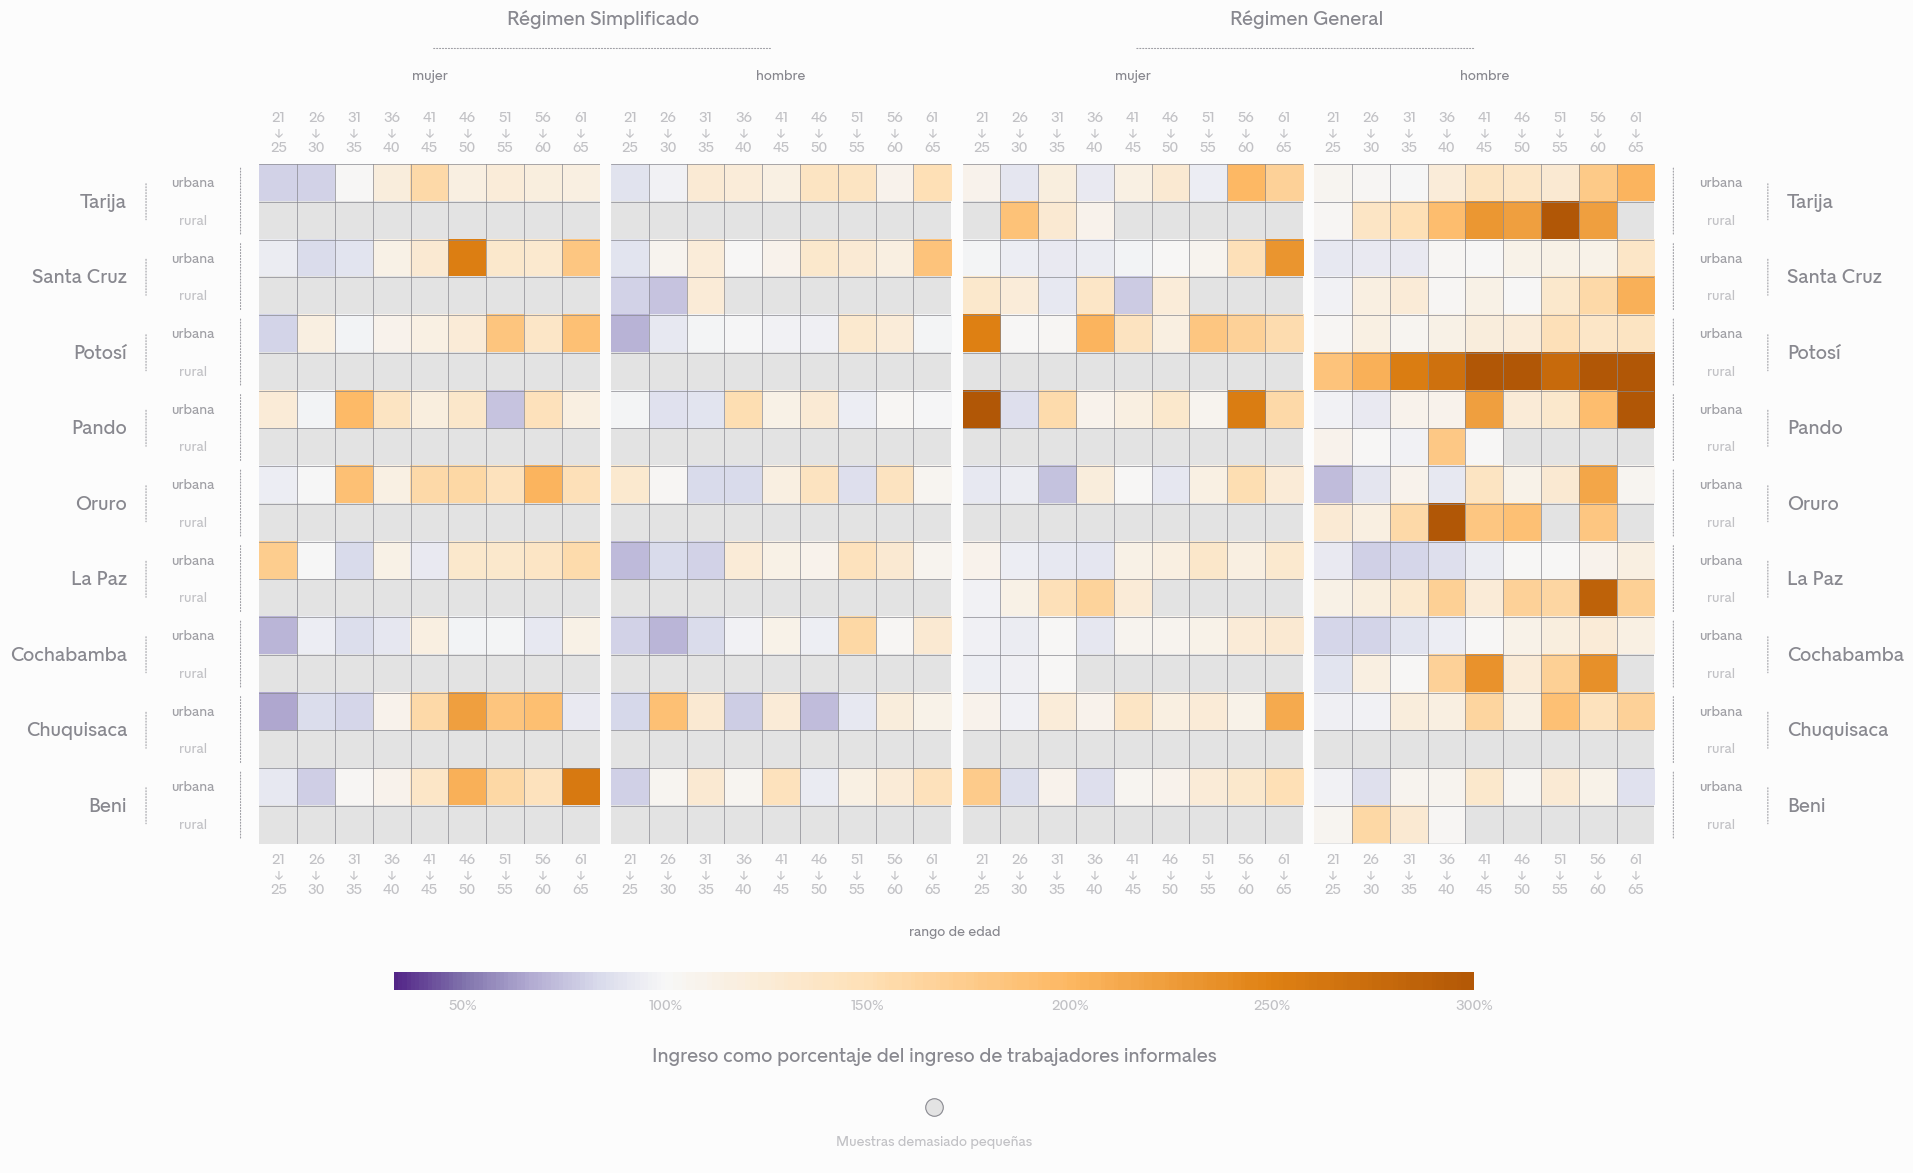

<p class="caption"><em>Ingreso de trabajadores formales como porcentaje del ingreso de informales entre 2015 y 2021, con datos de la Encuesta Continua de Empleo</em> </p>

In [743]:
seleccion, edades = get_edad_nit_comparisons(df, dfi, 10, 20, 65)
plot_matrix_comparisons(seleccion, empty, 'edad_range', edades, ['{}\n↓\n{}'.format(e+1, e + 5) for e in edades], 'rango de edad')

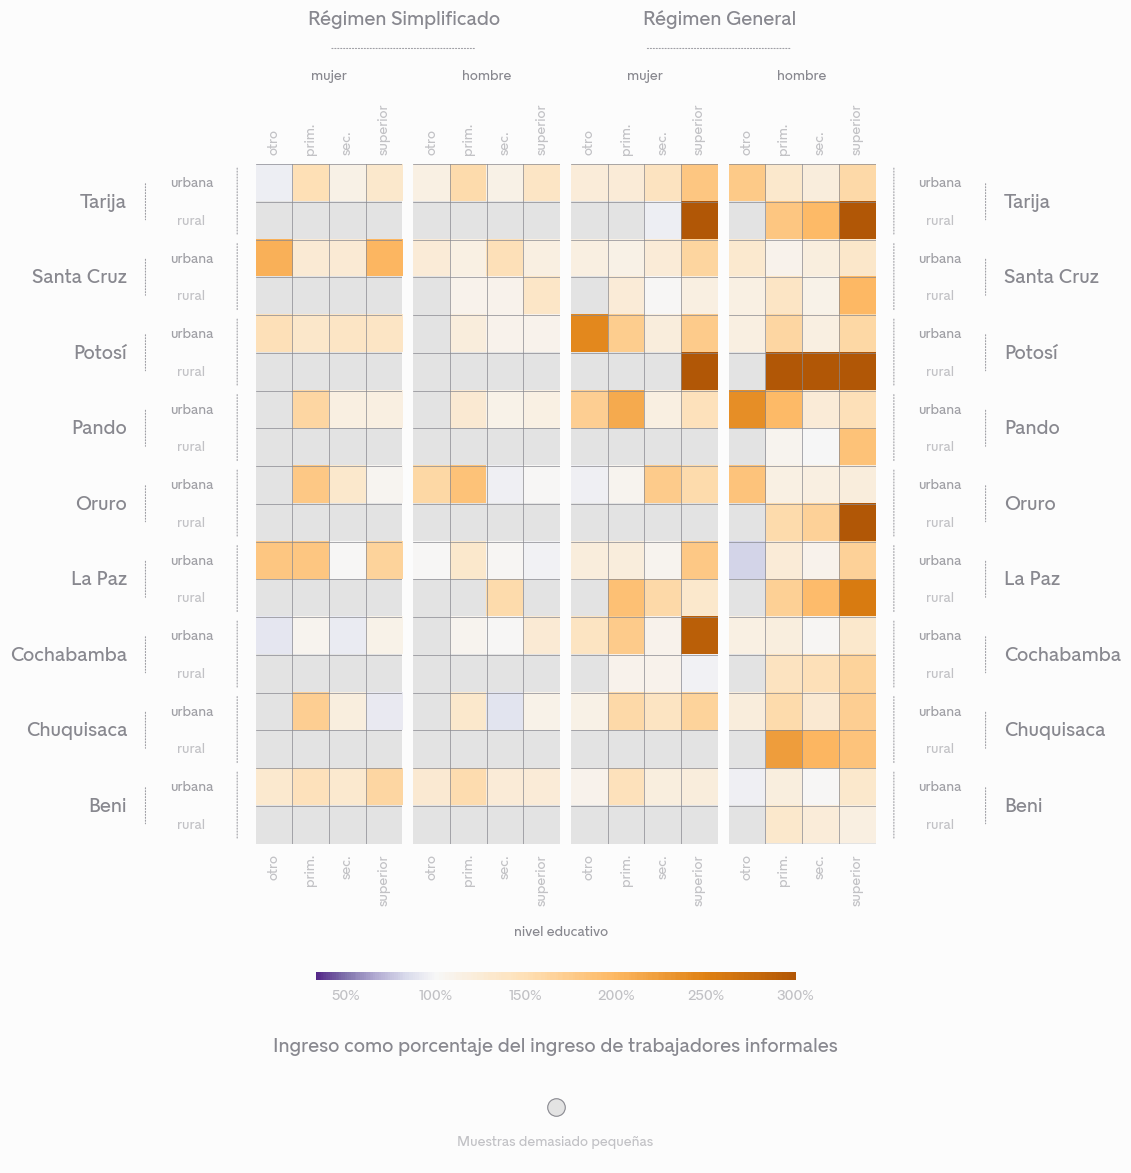

<p class="caption"><em>Ingreso de trabajadores formales como porcentaje del ingreso de informales entre 2015 y 2021, con datos de la Encuesta Continua de Empleo</em> </p>

In [744]:
seleccion = get_educacion_nit_comparisons(df, dfi, 10, True)
plot_matrix_comparisons(seleccion, empty, 'nivel_educativo', ['otro', 'primaria', 'secundaria', 'superior'], ['otro', 'prim.', 'sec.', 'superior'], 'nivel educativo', tick_rotation=90)